## Reinforcement Learning - Tetris

The current project is a heuristic model that uses a reward function with a greedy strategy to play Tetris. It was developed for the Reinformcement Learning course at FGV-EMAp. The students are:

- Bruno Lunardon
- George Dutra
- Zuilho Segundo

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import torch
from IPython.display import clear_output
import cv2
from tetris import Tetris
import multiprocessing as mp
from skopt import gp_minimize
from skopt.space import Real
import seaborn as sns

In [2]:
# Specs of the game
OPT = {"width": 10, "height": 20, "block_size": 30, "fps": 300, "saved_path": "trained_models", "output": "output.mp4"}

In [4]:
# Play a single game using the heruistic reward
def heuristic_game(w1,w2,w3,w4,opt,output_name=None):
    """Play a game with the given weights for the heuristic reward (HR) and return 
    the number of cleared lines

    Parameters
    ----------
    w1 : float
        Weight for the number of cleared lines in the HR range [0,1]
    w2 : float
        Weight for the number of holes in the HR range [0,1]
    w3 : float
        Weight for the bumpiness in the HR range [0,1]
    w4 : float
        Weight for the height in the HR range [0,1]
    opt : dict
        Dictionary containing the specs of the game
    output_name : str, optional
        Name of the output video file, by default None
    
    Returns
    -------
    int
        Number of cleared lines
    """


    # Create the game environment
    env = Tetris(width=opt["width"], height=opt["height"], block_size=opt["block_size"])
    env.reset()
    
    # Create the video writer if output_name is not None
    if output_name is not None:
        out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MJPG"), opt["fps"],
                          (int(1.5*opt["width"]*opt["block_size"]), opt["height"]*opt["block_size"]))       
        render = True
    else:
        render = False


    while True:
        # Get the next states and actions
        next_steps = env.get_next_states()
        next_actions, _ = zip(*next_steps.items())
        
        # Stack all tensors to form a 2D tensor
        stacked_tensors = torch.stack(_)
        
        # Calculate the heuristic reward (HR) for every possible action
        # HR = w1*lines_cleared-w2*holes-w3*bumpiness-w4*height
        HR = w1*stacked_tensors[:, 0]-w2*stacked_tensors[:, 1]-w3*stacked_tensors[:, 2]-w4*stacked_tensors[:, 3]
        
        # Find the maximum of the HRs
        max_score = torch.max(HR)

        # Find the index of the tensor(s) with the maximum HR
        indices = (HR == max_score).nonzero(as_tuple=True)[0]
    
        # If there are multiple tensors with the same maximum HR, choose one randomly
        random_index = random.randint(0, len(indices)-1)

        # Perform the next action
        _, done = env.step(next_actions[indices[random_index]], render=render,video=out)

        # If the game is done, break the loop
        if done:
            if output_name is not None:
                out.release()
                # Very important to release the video writer in jupyter notebook
                # Otherwise the kernel will die
                cv2.destroyAllWindows()
            break

    # Return the number of cleared lines in that game
    return env.cleared_lines

In [4]:
# Play N games using the heruistic reward
def heuristic_gameS(w1,w2,w3,w4,opt,N,output_name=None):
    """Play M games with the given weights for the heuristic reward (HR) and return
    the average number of cleared lines

    Parameters
    ----------
    w1 : float
        Weight for the number of cleared lines in the HR range [0,1]
    w2 : float
        Weight for the number of holes in the HR range [0,1]
    w3 : float
        Weight for the bumpiness in the HR range [0,1]
    w4 : float
        Weight for the height in the HR range [0,1]
    opt : dict
        Dictionary containing the specs of the game
    N : int
        Number of games to play
    output_name : str, optional
        Name of the output video file, by default None
        
    Returns
    -------
    float
        Average number of cleared lines
    """
    
    # Create the environment
    env = Tetris(width=opt["width"], height=opt["height"], block_size=opt["block_size"])
    env.reset()
    
    sum_linhas = 0
    
    # Create the video writer if output_name is not None
    if output_name is not None:
        out = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*"MJPG"), opt["fps"],
                          (int(1.5*opt["width"]*opt["block_size"]), opt["height"]*opt["block_size"]))       
        render = True
    else:
        render = False

    # Play the game M times
    for i in range(N):
        while True:

            # Get the next states and actions
            next_steps = env.get_next_states()
            next_actions, _ = zip(*next_steps.items())
            
            # Stack all tensors to form a 2D tensor
            stacked_tensors = torch.stack(_)
            
            # Calculate the heuristic reward (HR) for every possible action
            # HR = w1*lines_cleared-w2*holes-w3*bumpiness-w4*height
            HR = w1*stacked_tensors[:, 0]-w2*stacked_tensors[:, 1]-w3*stacked_tensors[:, 2]-w4*stacked_tensors[:, 3]
            
            # Find the maximum of the HRs
            max_score = torch.max(HR)

            # Find the index of the tensor(s) with the maximum HR
            indices = (HR == max_score).nonzero(as_tuple=True)[0]
        
            # If there are multiple tensors with the same maximum HR, choose one randomly
            random_index = random.choice(indices)

            # Perform the next action
            _, done = env.step(next_actions[indices[random_index]], render=render,video=out)

                
            if done:
                if output_name is not None:
                    out.release()
                    # Very important to release the video writer in jupyter notebook
                    # Otherwise the kernel will die
                    cv2.destroyAllWindows()
                break
        
        # Add the number of cleared lines to the sum
        sum_linhas += env.cleared_lines

        # Reset the environment for the next game
        env.reset()

    return sum_linhas/N

In [5]:
# Setup for a bayesian optimization using Gaussian Processes
# The objective function is the heuristic_gameS function
# The space is the range of the weights
# The number of calls is the number of games to play
# The number of random starts is the number of random games to play before the bayesian optimization

# Be aware that this will take a long time to run on my machine it took roughly 5 hours to run 1250 games

def objective(weights):
    opt = {"width": 10, "height": 20, "block_size": 30, "fps": 60, "saved_path": "trained_models", "output": "output.mp4"}
    w1,w2,w3,w4=weights
    return-heuristic_gameS(w1,w2,w3,w4,opt,50)
    
space = [Real(0, 1, name="w1"),
         Real(0, 1, name="w2"),
         Real(0, 1, name="w3"),
         Real(0, 1, name="w4")]

#result=gp_minimize(objective,space,n_calls=25,random_state=0, verbose=True,n_random_starts=10)

#On the bopt.py file there is a setup for a bayesian optimization where the game are run in parallel
#I didn't use it because, but it should be way faster than the setuo above.


In [3]:
#Get the results from the optimization
df=pd.read_csv('..\\data\\25pt_50g.csv')
arr=df.to_numpy()
ws=arr[:,0:4]
best_ws=arr[-1,0:4]

#Play a game with the best weights
#heuristic_game(best_ws[0],best_ws[1],best_ws[2],best_ws[3],OPT,output_name="best.mp4")

[   42.76    41.3     33.84  2549.66   927.74   168.92   141.4   3617.36
    19.26    18.4   3141.08  3637.4   1898.84  3421.7   3053.7   2096.38
  2478.12  1579.92  2466.44  3846.5   2952.8   3087.54  3175.54  3132.2
 14549.06]


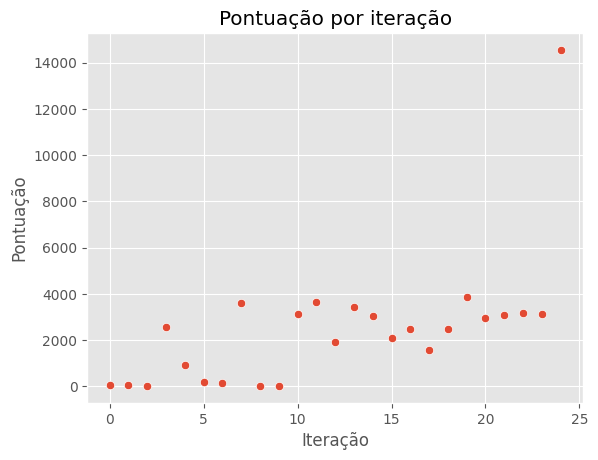

In [5]:
sns.scatterplot(x=np.arange(0,25),y=arr[:,4])
plt.xlabel('Iteração')
plt.ylabel('Pontuação')
plt.title('Pontuação por iteração')
plt.show()

C:\Users\lunar\AppData\Local\Temp\ipykernel_32560\3710390979.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.1)


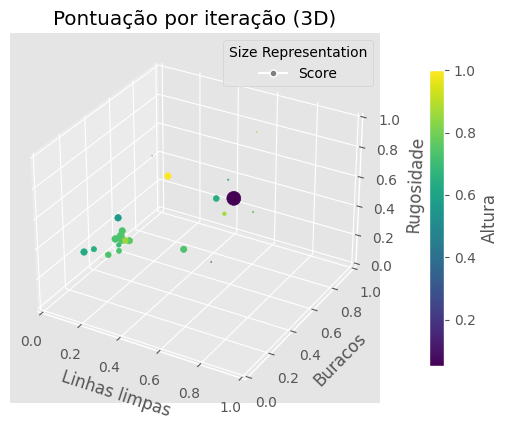

In [15]:
x = arr[:,0]
y = arr[:,1]
z = arr[:,2]
colors = arr[:,3]
sizes = arr[:,4]

sizes_normalized = (sizes - sizes.min())/(sizes.max() - sizes.min())
sizes_scaled = sizes_normalized * (100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=colors, s=sizes_scaled, depthshade=False)

# Colorbar adjustment to possibly prevent overlap
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.1)
cbar.set_label('Altura')

# Add a legend for size representation
# You can adjust these as per your data's min, max, and mean sizes for more clarity
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=15)]
labels = ['Score']
ax.legend(handles, labels, title="Size Representation", loc="upper right")

ax.set_xlabel('Linhas limpas')
ax.set_ylabel('Buracos')
ax.set_zlabel('Rugosidade')
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.set_title('Pontuação por iteração (3D)')
plt.show()

In [17]:
# Visualize the weights and lines cleared during the optimization
df['média de linhas limpas']=df['score']
df[['w1','w2','w3','w4','média de linhas limpas']]

,w1,w2,w3,w4,média de linhas limpas
0,0.592845,0.844266,0.857946,0.847252,42.76
1,0.623564,0.384382,0.297535,0.056713,41.30
2,0.272656,0.477665,0.812169,0.479977,33.84
3,0.392785,0.836079,0.337396,0.648172,2549.66
4,0.368242,0.957155,0.140351,0.870087,927.74
5,0.473608,0.800911,0.520477,0.678880,168.92
6,0.720633,0.582020,0.537373,0.758616,141.40
7,0.105908,0.473600,0.186332,0.736918,3617.36
8,0.216550,0.135218,0.324141,0.149675,19.26
9,0.222321,0.386489,0.902598,0.449950,18.40
